In [1]:
import numpy as np
import emcee
import corner
from scipy import integrate
from nevin import nevin as Nevin

In [2]:
# -- plotting --
import matplotlib as mpl 
import matplotlib.pyplot as plt 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

# Example 0: Fitting a line to data --- 1D Gauss likelihood, flat prior
As the first example, lets take the simplest possible scenario of fitting a line to data. 

$${\rm data} = \{(x_i, y_i)\}_{i = 1}^{N_{\rm data}}$$

where $y$ has a linear relation with $x$ with some constant Gaussian noise

$$y \sim \mathcal{N}(-x + 0.5, \sigma)$$ 

We'll fix $\sigma = 0.1$. Meanwhile, our model will be equally simplistic: 

$$m(x, \theta) = -x + \theta$$

So we're just inferring the $y$-intercept of a line. Then the likelihood is a 1D Gaussian: 

$$p(d|\theta) = \mathcal{L}(\theta) = \prod\limits_{i=1}^{N_{\rm data}}\frac{1}{\sqrt{2\pi\sigma_i^2}} exp\left(-\frac{(d_i - m(\theta)_i)^2}{2\sigma_i^2} \right)$$

and we'll use a simple flat prior 
$$p(\theta) = 1~{\rm if}~0 < \theta < 1; 0~{\rm else}$$

With this flat prior, things become pretty trivial. The evidence, which is the integral
$$p({\rm data}) = \int_{\Omega_\theta} p({\rm data}|\theta) p(\theta)~{\rm d}\theta$$
($\Omega_\theta$ is the parameter space defined by the flat prior), becomes
$$p({\rm data}) = \int_{\Omega_\theta} p({\rm data}|\theta)~{\rm d}\theta$$

Things should be equally trivial for the log evidence estimator, since the KL divergence in this case simply becomes
$$D_{\rm KL} (p(\theta|{\rm data} || p(\theta) = \int_{\Omega_\theta} p(\theta |{\rm data}) \log \frac{p(\theta |{\rm data})}{p(\theta)} {\rm d}\theta = \int_{\Omega_\theta} p(\theta |{\rm data}) \log p(\theta |{\rm data}) {\rm d}\theta$$

Text(0, 0.5, 'y')

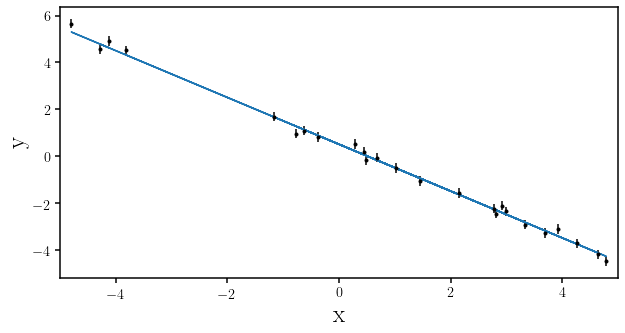

In [3]:
theta_true = 0.5

def model(theta, x): 
    '''forward model
    '''
    return -x + theta

N_data = 25

np.random.seed(0)
sig_noise = 0.2
x_data = 10.*np.random.uniform(size=N_data)-5.
y_data =  model(theta_true, x_data) + sig_noise * np.random.randn(N_data)
y_err = np.repeat(sig_noise, N_data)

fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(x_data, model(theta_true, x_data), c='C0')
sub.errorbar(x_data, y_data, yerr=y_err, fmt='.k')
sub.set_xlabel('x', fontsize=25)
sub.set_xlim(-5, 5)
sub.set_ylabel('y', fontsize=25)

In [4]:
prior_lim = [[0., 1.]]

In [5]:
def lnlikelihood(theta): 
    ''' gaussian likelihood
    '''
    y_model = model(theta, x_data)
    chi2 = np.sum((y_data - y_model)**2/y_err**2)
    
    lnlike = -0.5 *chi2 + np.log(2.*np.pi*y_err**2).sum()
    return lnlike

def likelihood(theta): 
    return np.exp(lnlikelihood(theta))

def lnprior(theta): 
    '''flat prior
    '''    
    if prior_lim[0][0] < theta < prior_lim[0][1]:
        _prior = 1./(prior_lim[0][1] - prior_lim[0][0])
        return np.log(_prior)
    return -np.inf

def lnposterior(theta): 
    return lnlikelihood(theta) + lnprior(theta)

In [6]:
N_prior = 10000
prior_sample = np.array([np.random.uniform(lim[0], lim[1], size=N_prior) for lim in prior_lim]).T

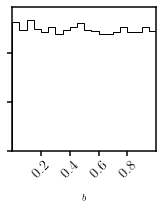

In [7]:
fig = corner.corner(prior_sample, labels=['$b$'])

In [8]:
from scipy.optimize import minimize

nll = lambda *args: -lnlikelihood(*args)
initial = np.array(theta_true) + 0.1 * np.random.randn(1)

soln = minimize(nll, initial)
theta_ml = soln.x

pos = soln.x + 1e-4 * np.random.randn(32, 1)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnposterior)
sampler.run_mcmc(pos, 5000, progress=True)

100%|██████████| 5000/5000 [00:05<00:00, 988.95it/s] 


State([[0.54522755]
 [0.53100219]
 [0.55398807]
 [0.48790744]
 [0.55078733]
 [0.48767038]
 [0.48518126]
 [0.53087523]
 [0.51865991]
 [0.54909484]
 [0.51809927]
 [0.57538038]
 [0.51472385]
 [0.55963609]
 [0.47791329]
 [0.53639709]
 [0.5539316 ]
 [0.57166664]
 [0.52253708]
 [0.52444656]
 [0.55397542]
 [0.54660962]
 [0.52606887]
 [0.49976088]
 [0.50682004]
 [0.53673078]
 [0.4956353 ]
 [0.54005627]
 [0.52170926]
 [0.51885416]
 [0.56790151]
 [0.46231394]], log_prob=[-45.31170537 -45.21011581 -45.43719558 -45.67429356 -45.38578552
 -45.68005706 -45.74269367 -45.20977856 -45.22444459 -45.36118878
 -45.22735607 -45.94520493 -45.24903684 -45.54353191 -45.94774721
 -45.23375581 -45.43623308 -45.83649684 -45.20968693 -45.20587185
 -45.43697979 -45.32831615 -45.20442104 -45.43089497 -45.32766303
 -45.23581541 -45.50564656 -45.26014336 -45.21204902 -45.22348163
 -45.73508442 -46.49932988], blobs=None, random_state=('MT19937', array([1195236781,   67414953,  584072436,  582577159, 3943912027,
      

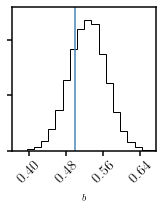

In [9]:
chain = sampler.get_chain(discard=100, thin=10, flat=True)
fig = corner.corner(chain, labels=['$b$'], truths=[theta_true])

In [10]:
lnlike_chain = np.array([lnlikelihood(tt) for tt in chain])

Lets first calculate the evidence by explicitly evaluating the integral
$$p({\rm data}) = \int_{\Omega_\theta} p({\rm data}|\theta) p(\theta)~{\rm d}\theta$$
which in our case is 
$$p({\rm data}) = \int_{\Omega_\theta} p({\rm data}|\theta)~{\rm d}\theta$$

In [11]:
evidence, _ = integrate.quad(likelihood, prior_lim[0][0], prior_lim[0][1])
evidence /= (prior_lim[0][1] - prior_lim[0][0])
print('evidence from integrating the likelihood')
print(evidence)

evidence from integrating the likelihood
2.3397606313160285e-21


In [12]:
uniq_chain, iuniq = np.unique(chain, return_index=True)

log_evid = Nevin.log_evidence(np.atleast_2d(uniq_chain).T, lnlike_chain[iuniq], prior_sample, silent=False)
print('evidence from estimator')
print(np.exp(log_evid))

<ln L> = -45.704759
  epsilons  [0.01278185 0.00031637 0.00031637 ... 0.00062836 0.00288296 0.00648057]
  l_i  [1 1 1 ... 1 1 1]
  k_i  [255  14  12 ...  16  57 113]
  first term = 0.115073
  digamma term = 2.132672
D_KL = 1.798071
evidence from estimator
2.3430585561754e-21


**estimator is consistent**. 

# Example 2: Fitting a line to data --- 2D Gauss likelihood, flat prior
same as above but now slope is a free parameter

Text(0, 0.5, 'y')

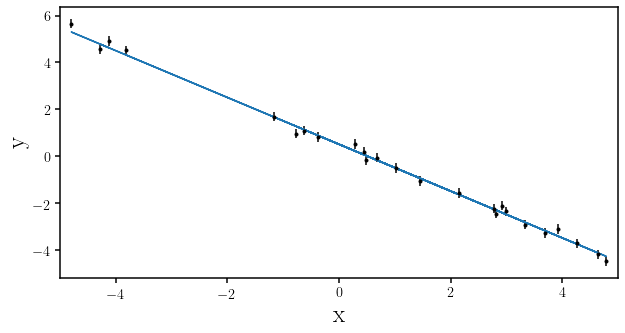

In [13]:
theta_true = [-1, 0.5]

def model(theta, x): 
    '''forward model
    '''
    return theta[0] * x + theta[1]

N_data = 25

np.random.seed(0)
sig_noise = 0.2
x_data = 10.*np.random.uniform(size=N_data)-5.
y_data =  model(theta_true, x_data) + sig_noise * np.random.randn(N_data)
y_err = np.repeat(sig_noise, N_data)

fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(x_data, model(theta_true, x_data), c='C0')
sub.errorbar(x_data, y_data, yerr=y_err, fmt='.k')
sub.set_xlabel('x', fontsize=25)
sub.set_xlim(-5, 5)
sub.set_ylabel('y', fontsize=25)

In [14]:
prior_lim = [[-5, 0], [0., 1.]]

In [15]:
def lnlikelihood(theta): 
    ''' gaussian likelihood
    '''
    N = theta.shape[0]
    y_model = model(theta, x_data)
    chi2 = np.sum((y_data - y_model)**2/y_err**2)
    lnlike = -0.5 * chi2 + np.log(2.*np.pi*y_err**2).sum()
    return lnlike

def likelihood(theta): 
    return np.exp(lnlikelihood(theta))

def lnprior(theta): 
    '''flat prior
    '''    
    if prior_lim[0][0] < theta[0] < prior_lim[0][1] and prior_lim[1][0] < theta[1] < prior_lim[1][1]:
        _prior = 1./(prior_lim[0][1] - prior_lim[0][0])/(prior_lim[1][1] - prior_lim[1][0])
        return np.log(_prior)
    return -np.inf

def lnposterior(theta): 
    return lnlikelihood(theta) + lnprior(theta)

In [16]:
N_prior = 10000
prior_sample = np.array([np.random.uniform(lim[0], lim[1], size=N_prior) for lim in prior_lim]).T

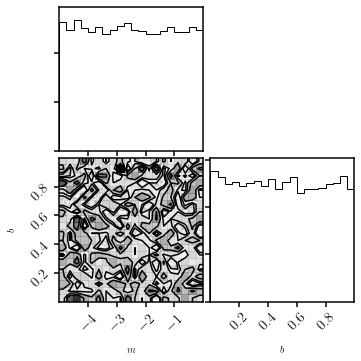

In [17]:
fig = corner.corner(prior_sample, labels=['$m$', '$b$'])

In [18]:
nll = lambda *args: -lnlikelihood(*args)
initial = np.array(theta_true) + 0.1 * np.random.randn(2)

soln = minimize(nll, initial)
theta_ml = soln.x

pos = soln.x + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnposterior)
sampler.run_mcmc(pos, 5000, progress=True)

100%|██████████| 5000/5000 [00:05<00:00, 939.16it/s]


State([[-1.01706857  0.49563913]
 [-0.99463411  0.60909946]
 [-1.01802444  0.56649761]
 [-0.98646702  0.50596128]
 [-1.0297757   0.5130659 ]
 [-0.9941446   0.52115771]
 [-1.02402985  0.59274355]
 [-1.00663129  0.58195734]
 [-1.0048983   0.56055381]
 [-1.02263584  0.56070188]
 [-1.01127217  0.4790587 ]
 [-1.02320614  0.55878907]
 [-0.99660266  0.51351449]
 [-1.02732354  0.56374923]
 [-0.98024289  0.51443331]
 [-0.99945984  0.59079616]
 [-1.00058667  0.56084752]
 [-1.00830019  0.44925787]
 [-1.02523183  0.57517388]
 [-1.01060501  0.57204719]
 [-1.04371703  0.51995341]
 [-0.99969612  0.5613002 ]
 [-1.01357668  0.56027593]
 [-1.0415458   0.52382221]
 [-1.01082566  0.52439571]
 [-1.00076642  0.45714729]
 [-0.98122074  0.5692456 ]
 [-1.00614012  0.55076306]
 [-1.01971376  0.57772595]
 [-1.00686775  0.5847799 ]
 [-1.03042386  0.55887681]
 [-1.01344806  0.57471014]], log_prob=[-47.04727309 -49.63382736 -46.56029452 -48.21984136 -47.49973832
 -47.30044273 -47.2182111  -47.22693884 -46.8083668  

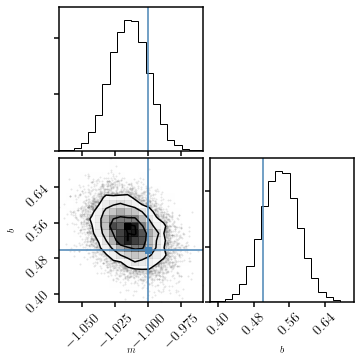

In [19]:
chain = sampler.get_chain(discard=100, thin=10, flat=True)
fig = corner.corner(chain, labels=['$m$', '$b$'], truths=theta_true)

In [20]:
_likelihood = lambda y, x: likelihood(np.array([y,x]))
evidence, _ = integrate.dblquad(_likelihood, prior_lim[1][0], prior_lim[1][1], lambda x: prior_lim[0][0], lambda x: prior_lim[0][1])
evidence /= (prior_lim[0][1] - prior_lim[0][0])
print('evidence from integrating the likelihood')
print(evidence)

evidence from integrating the likelihood
2.613389137691037e-25


In [21]:
lnlike_chain = np.array([lnlikelihood(tt) for tt in chain])

In [22]:
log_evid = Nevin.log_evidence(chain, lnlike_chain, prior_sample, silent=False)
print('evidence from estimator')
print(np.exp(log_evid))

<ln L> = -45.721869
  epsilons  [0.01684253 0.00721258 0.01220292 ... 0.00773628 0.00699415 0.01710189]
  l_i  [1978   99  489 ...  316  376 2208]
  k_i  [1 1 1 ... 1 1 1]
  first term = 0.008425
  digamma term = 6.896488
D_KL = 6.455176
evidence from estimator
2.1867408814599582e-23


Also consistent. Yay. 